# UTS Penambangan Data dan Analisis Bisnis

In [323]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
import category_encoders as ce
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from catboost import CatBoostClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import joblib
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor

In [303]:
import warnings
warnings.filterwarnings("ignore")

In [251]:
data = pd.read_csv("data/Titanic-Dataset.csv")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


## 1. Eksplorasi Awal

### a. Berapa Jumlah total penumpang yang ada?

In [252]:
total_passengers = len(data)
print("Total passengers:", total_passengers)

Total passengers: 891


### b. Berapa jumlah penumpang yang selamat dan tidak selamat, Tampilkan dalam bentuk grafik?

          Status  Jumlah
0  Tidak Selamat     549
1        Selamat     342


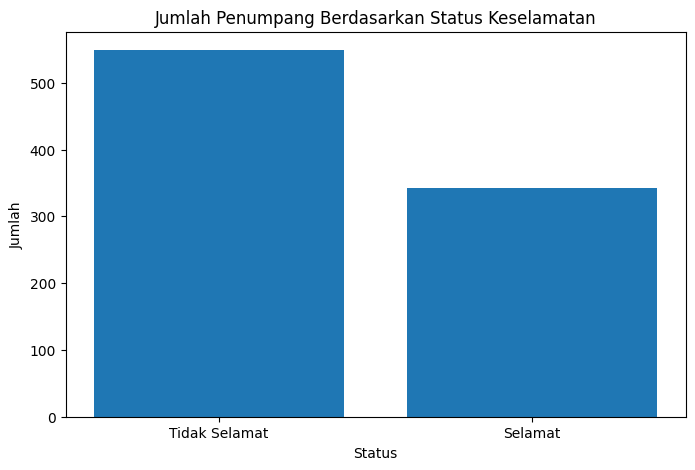

In [253]:
survival_counts = data['Survived'].value_counts()
survival_table = pd.DataFrame({
    'Status': ['Tidak Selamat', 'Selamat'],
    'Jumlah': [survival_counts[0], survival_counts[1]]
})
print(survival_table)

# Visualisasi hasil menggunakan grafik
plt.figure(figsize=(8, 5))
plt.bar(survival_table['Status'], survival_table['Jumlah'])
plt.title('Jumlah Penumpang Berdasarkan Status Keselamatan')
plt.xlabel('Status')
plt.ylabel('Jumlah')
plt.show()   

### c. Berapa rata-rata umur penumpang? dan siapa penumpang termuda dan tertua?

In [254]:
average_age = data['Age'].mean()
youngest_passenger = data.loc[data['Age'].idxmin()]
oldest_passenger = data.loc[data['Age'].idxmax()]
print("Rata-rata umur penumpang:", average_age,"\n")
print("Identitas Penumpang Termuda:")
print(youngest_passenger,"\n")
print("Identitas Penumpang Tertua:")
print(oldest_passenger)

Rata-rata umur penumpang: 29.69911764705882 

Identitas Penumpang Termuda:
PassengerId                                804
Survived                                     1
Pclass                                       3
Name           Thomas, Master. Assad Alexander
Sex                                       male
Age                                       0.42
SibSp                                        0
Parch                                        1
Ticket                                    2625
Fare                                    8.5167
Cabin                                      NaN
Embarked                                     C
Name: 803, dtype: object 

Identitas Penumpang Tertua:
PassengerId                                     631
Survived                                          1
Pclass                                            1
Name           Barkworth, Mr. Algernon Henry Wilson
Sex                                            male
Age                                           

### d. Berapakah jumlah penumpang berdasarkan jenis kelamin? Siapa yang paling banyak? Visualisasikan

  Jenis Kelamin  Jumlah
0          male     577
1        female     314
Jenis kelamin yang paling banyak: male


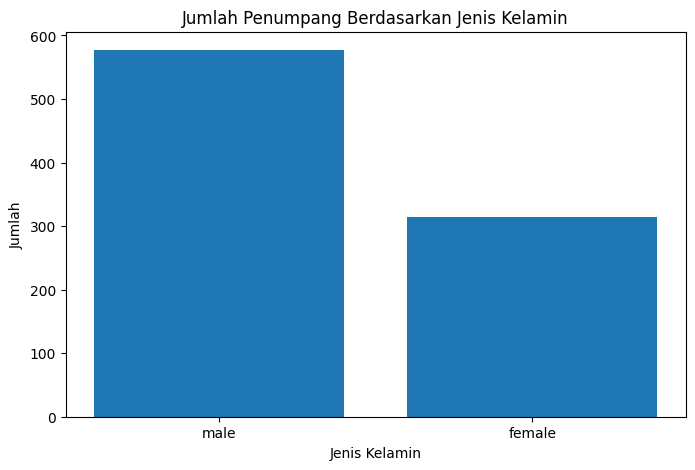

In [255]:
gender_counts = data['Sex'].value_counts()

gender_table = pd.DataFrame({
    'Jenis Kelamin': gender_counts.index,
    'Jumlah': gender_counts.values
})
print(gender_table)

gender_terbanyak = gender_counts.idxmax()
print(f"Jenis kelamin yang paling banyak: {gender_terbanyak}")

plt.figure(figsize=(8, 5))
plt.bar(gender_table["Jenis Kelamin"], gender_table["Jumlah"])
plt.title('Jumlah Penumpang Berdasarkan Jenis Kelamin')
plt.xlabel('Jenis Kelamin')
plt.ylabel('Jumlah')
plt.show()

### e. Tampilkan jumlah penumpang berdasarkan kelas (Pclass) dan berapa persen dari total data yang berada di kelas 1? Visualkan

Jumlah penumpang di kelas 1: 216
Jumlah penumpang di kelas 2: 184
Jumlah penumpang di kelas 3: 491


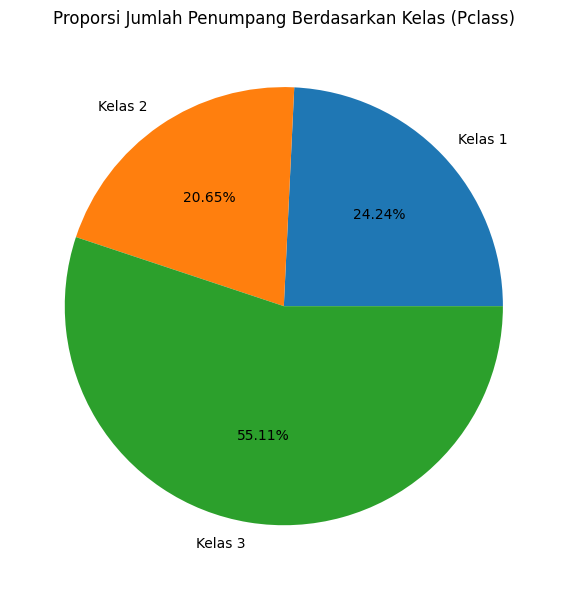

In [256]:
pclass_counts = data['Pclass'].value_counts().sort_index()
for i in pclass_counts.index:
    print(f"Jumlah penumpang di kelas {i}:", pclass_counts[i])

plt.figure(figsize=(12, 6))
plt.pie(pclass_counts, labels=[f"Kelas {i}" for i in pclass_counts.index], autopct='%1.2f%%')
plt.title('Proporsi Jumlah Penumpang Berdasarkan Kelas (Pclass)')
plt.tight_layout()
plt.show()

### 2. Pre-Processing

In [257]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


##### Mengatasi missing value 

##### a. Apakah terdapat missing value pada data tersebut?

In [258]:
data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

### b. Jika ya, apa anda dilakukan?

##### Menangani data hilang pada kolom age dengan imputasi mean

In [259]:
data['Age'] = data['Age'].fillna(np.mean(data['Age']))

##### Menghapus data hilang pada kolom embarked

In [260]:
data.dropna(subset=['Embarked'], inplace=True)

##### Menghapus kolom cabin

In [261]:
data.drop('Cabin', axis=1, inplace=True)

##### Mengecek ulang data hilang dalam dataset

In [262]:
data.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Embarked       0
dtype: int64

### c. Apakah terdapat outlier pada data tersebut? jelaskan apa itu outlier!

Boxplot untuk cek outlier

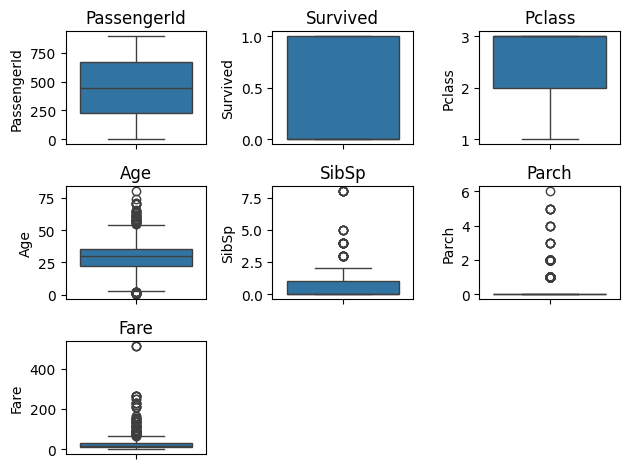

In [263]:

for i, col in enumerate(data.select_dtypes(include=["integer", "float"]).columns, start=1):
    plt.subplot(3, 3, i)
    sns.boxplot(y=data[col])
    plt.title(col)
plt.tight_layout()
plt.show()

##### d. Apakah outlier pada data tersebut perlu diatasi serta bagaimana cara mengatasinya?

##### Melihat data outlier pada kolom fare

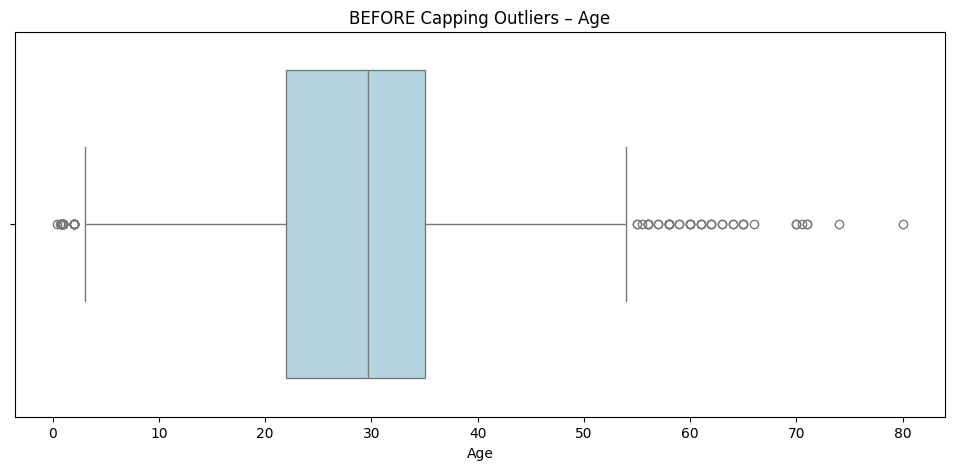

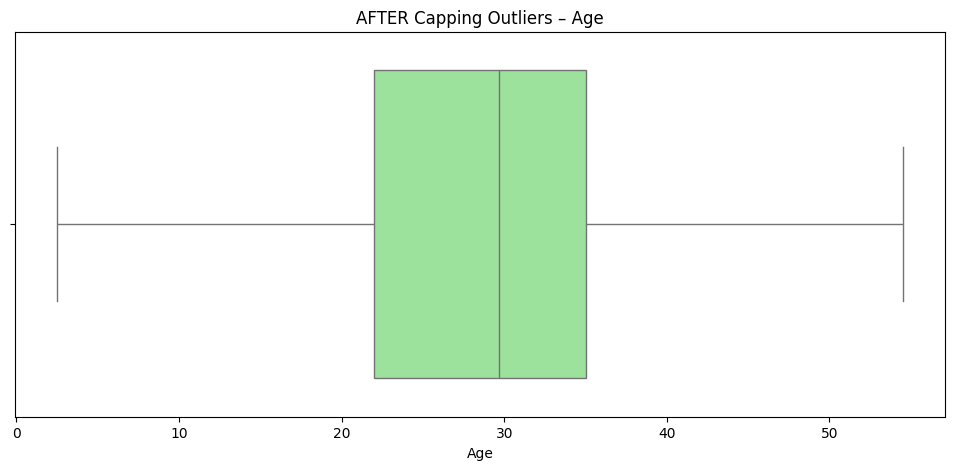

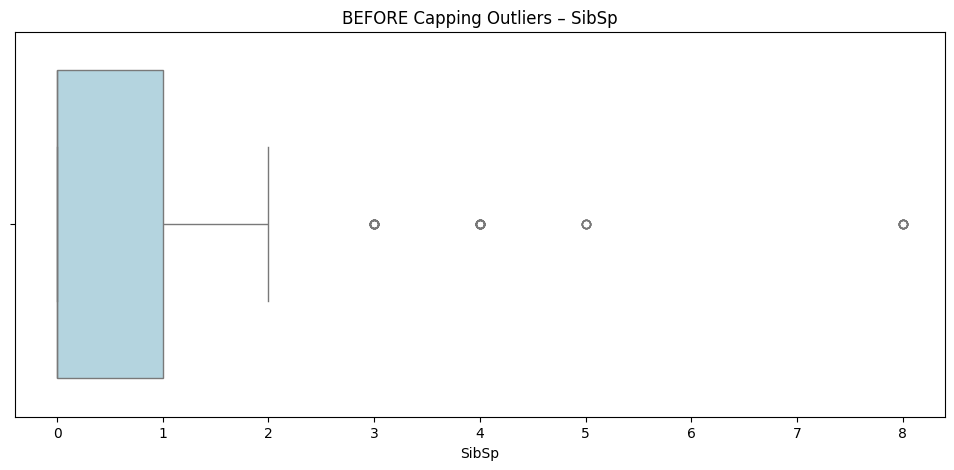

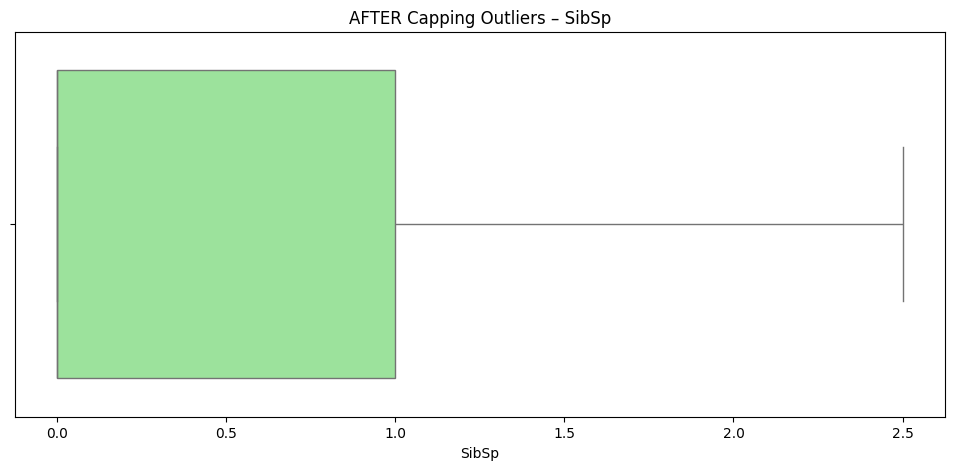

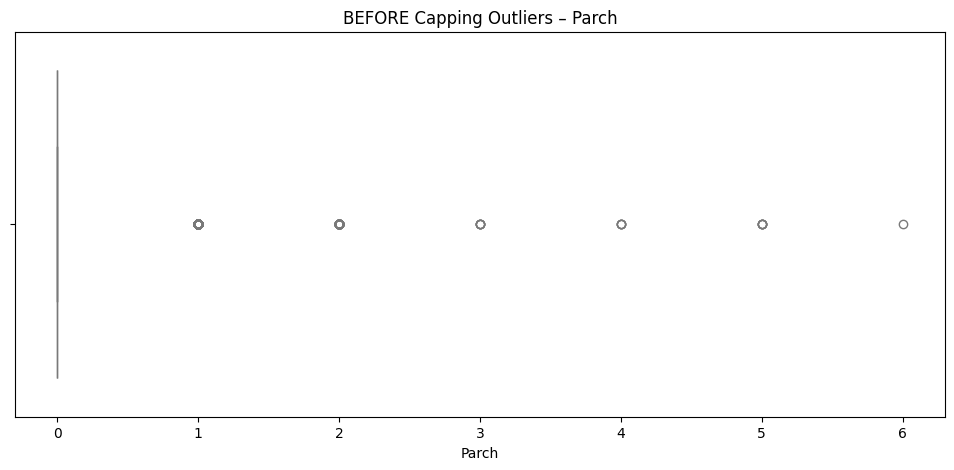

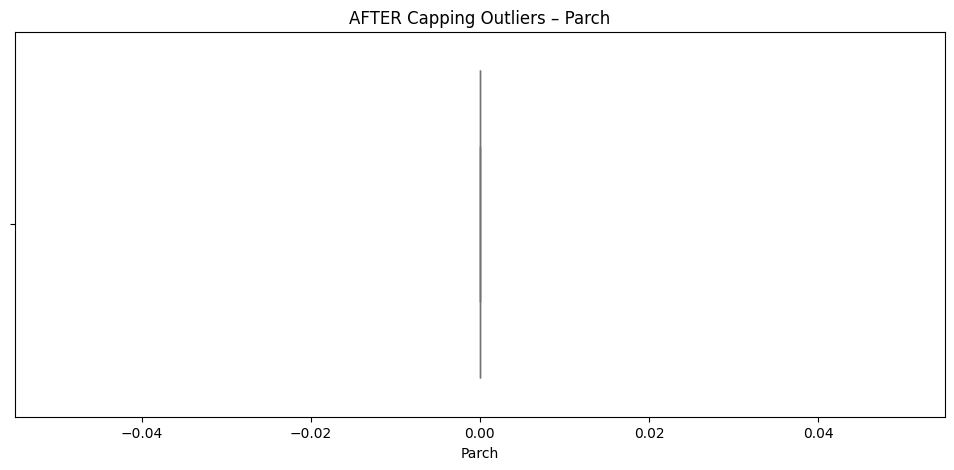

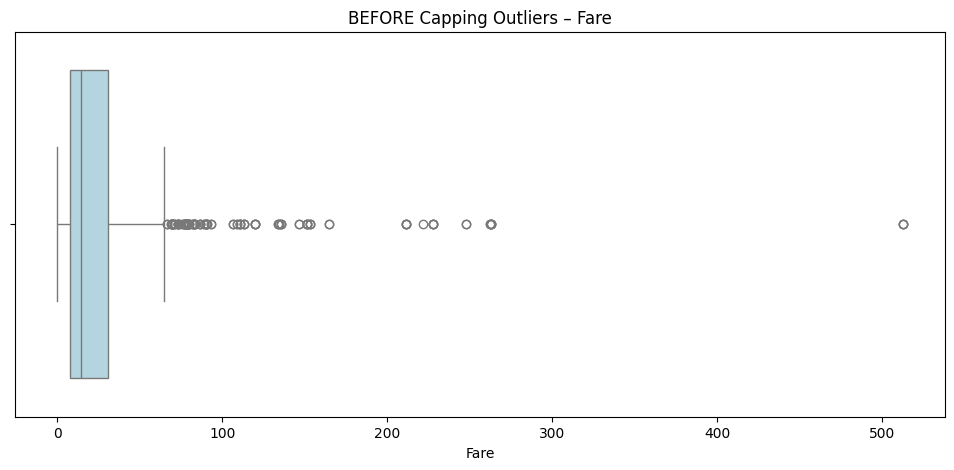

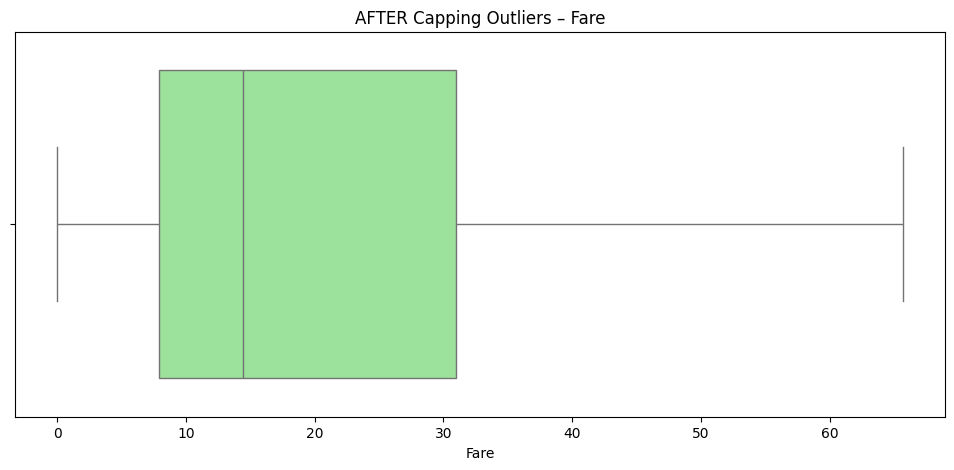

In [264]:
outlier_cols = ['Age', 'SibSp', 'Parch', 'Fare']

def cap_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    data[column] = np.where(data[column] < lower_bound, lower_bound,
                    np.where(data[column] > upper_bound, upper_bound, data[column]))
    return data

capped_data = data.copy()

# Loop semua kolom numerik
for col in outlier_cols:
    # Membuat boxplot sebelum capping
    plt.figure(figsize=(12, 5))
    sns.boxplot(x=capped_data[col], color='lightblue')
    plt.title(f'BEFORE Capping Outliers – {col}')
    plt.show()

    capped_data = cap_outliers_iqr(capped_data, col)

    # Membuat boxplot setelah capping
    plt.figure(figsize=(12, 5))
    sns.boxplot(x=capped_data[col], color='lightgreen')
    plt.title(f'AFTER Capping Outliers – {col}')
    plt.show()

### e. Jika dibutuhkan silakan lakukan transformasi/standarisasi/scalling terhadap data tersebut

In [265]:
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,S


##### Encoding data

In [267]:
data['Sex'] = data['Sex'].map({'male': 0, 'female': 1})

embarked_mapping = {'C': 0, 'Q': 1, 'S': 2}
data['Embarked'] = data['Embarked'].map(embarked_mapping)

print(data[['Sex', 'Embarked']].head())

   Sex  Embarked
0    0         2
1    1         0
2    1         2
3    1         2
4    0         2


In [268]:
data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",0,22.000000,1,0,A/5 21171,2.110213,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,38.000000,1,0,PC 17599,4.280593,0
2,3,1,3,"Heikkinen, Miss. Laina",1,26.000000,0,0,STON/O2. 3101282,2.188856,2
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,35.000000,1,0,113803,3.990834,2
4,5,0,3,"Allen, Mr. William Henry",0,35.000000,0,0,373450,2.202765,2
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",0,27.000000,0,0,211536,2.639057,2
887,888,1,1,"Graham, Miss. Margaret Edith",1,19.000000,0,0,112053,3.433987,2
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",1,29.699118,1,2,W./C. 6607,3.196630,2
889,890,1,1,"Behr, Mr. Karl Howell",0,26.000000,0,0,111369,3.433987,0


In [269]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    int64  
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Embarked     889 non-null    int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 83.3+ KB


##### Scaling Data

In [286]:
Features = data.drop(columns=["PassengerId", "Survived", "Name", "Ticket"])
Goal = data["Survived"]

In [287]:
Features

,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,3,0,22.000000,1,0,2.110213,2
1,1,1,38.000000,1,0,4.280593,0
2,3,1,26.000000,0,0,2.188856,2
3,1,1,35.000000,1,0,3.990834,2
4,3,0,35.000000,0,0,2.202765,2
...,...,...,...,...,...,...,...
886,2,0,27.000000,0,0,2.639057,2
887,1,1,19.000000,0,0,3.433987,2
888,3,1,29.699118,1,2,3.196630,2
889,1,0,26.000000,0,0,3.433987,0


In [288]:
Features = StandardScaler().fit_transform(Features)

In [292]:
Features

array([[ 0.82520863, -0.73534203, -0.59049493, ..., -0.47432585,
        -0.87759093,  0.58683958],
       [-1.57221121,  1.35991138,  0.64397101, ..., -0.47432585,
         1.36637963, -1.93955453],
       [ 0.82520863,  1.35991138, -0.28187844, ..., -0.47432585,
        -0.79628127,  0.58683958],
       ...,
       [ 0.82520863,  1.35991138,  0.00352373, ...,  2.00611934,
         0.24566301,  0.58683958],
       [-1.57221121, -0.73534203, -0.28187844, ..., -0.47432585,
         0.49106801, -1.93955453],
       [ 0.82520863, -0.73534203,  0.18104628, ..., -0.47432585,
        -0.81675534, -0.67635748]], shape=(889, 7))

In [293]:
Features = pd.DataFrame(Features)

In [294]:
Features

,0,1,2,3,4,5,6
0,0.825209,-0.735342,-0.590495,0.431350,-0.474326,-0.877591,0.586840
1,-1.572211,1.359911,0.643971,0.431350,-0.474326,1.366380,-1.939555
2,0.825209,1.359911,-0.281878,-0.475199,-0.474326,-0.796281,0.586840
3,-1.572211,1.359911,0.412509,0.431350,-0.474326,1.066796,0.586840
4,0.825209,-0.735342,0.412509,-0.475199,-0.474326,-0.781901,0.586840
...,...,...,...,...,...,...,...
884,-0.373501,-0.735342,-0.204724,-0.475199,-0.474326,-0.330815,0.586840
885,-1.572211,1.359911,-0.821957,-0.475199,-0.474326,0.491068,0.586840
886,0.825209,1.359911,0.003524,0.431350,2.006119,0.245663,0.586840
887,-1.572211,-0.735342,-0.281878,-0.475199,-0.474326,0.491068,-1.939555


In [296]:
Features.columns=["pclass","Sex", "Age","SibSp","Parch","Fare","Embarked"]

In [297]:
Features

,pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0.825209,-0.735342,-0.590495,0.431350,-0.474326,-0.877591,0.586840
1,-1.572211,1.359911,0.643971,0.431350,-0.474326,1.366380,-1.939555
2,0.825209,1.359911,-0.281878,-0.475199,-0.474326,-0.796281,0.586840
3,-1.572211,1.359911,0.412509,0.431350,-0.474326,1.066796,0.586840
4,0.825209,-0.735342,0.412509,-0.475199,-0.474326,-0.781901,0.586840
...,...,...,...,...,...,...,...
884,-0.373501,-0.735342,-0.204724,-0.475199,-0.474326,-0.330815,0.586840
885,-1.572211,1.359911,-0.821957,-0.475199,-0.474326,0.491068,0.586840
886,0.825209,1.359911,0.003524,0.431350,2.006119,0.245663,0.586840
887,-1.572211,-0.735342,-0.281878,-0.475199,-0.474326,0.491068,-1.939555


In [298]:
Goal

0      0
1      1
2      1
3      1
4      0
      ..
886    0
887    1
888    0
889    1
890    0
Name: Survived, Length: 889, dtype: int64

In [299]:
Features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   pclass    889 non-null    float64
 1   Sex       889 non-null    float64
 2   Age       889 non-null    float64
 3   SibSp     889 non-null    float64
 4   Parch     889 non-null    float64
 5   Fare      889 non-null    float64
 6   Embarked  889 non-null    float64
dtypes: float64(7)
memory usage: 48.7 KB


## 3. Modelling

### a. Jelaskan proses pembagian data menjadi data training dan testing dan alasan mengapa perlu membagi data tersebut.

Dalam modeling data dibagi menjadi 2 yaitu data training dan data testing. Data training digunakan untuk melatih model mengenali pola dalam data. Data testing digunakan untuk mengukur performa dari model pada data yang belum pernah dilihat sebelumnya. Pembagian data training dan testing dilakukan untuk menilai seberapa baik model bekerja diluar data latihannya, yang mencerminkan performa di dunia nyata.

### b. Berapa persen pembagiannya? Mengapa memilih membagi dengan proporsi tersebut?

In [330]:
X_train, X_test, Y_train, Y_test = train_test_split(Features, Goal, test_size= 0.2, random_state=1)

##### c. Buatlah model klasifikasi dari 3 algoritma yang berbeda. Jelaskan masing-masing model dan cara kerjanya

##### KNN

In [334]:
knn = KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, Y_train)
y_pred = knn.predict(X_test)

# Evaluasi model
print("Akurasi Klasifikasi:", accuracy_score(Y_test, y_pred))
print("Laporan Klasifikasi:\n", classification_report(Y_test, y_pred))

Akurasi Klasifikasi: 0.8033707865168539
Laporan Klasifikasi:
               precision    recall  f1-score   support

           0       0.78      0.92      0.85       105
           1       0.85      0.63      0.72        73

    accuracy                           0.80       178
   macro avg       0.82      0.78      0.79       178
weighted avg       0.81      0.80      0.80       178



Confusion Matrix:
 [[97  8]
 [27 46]]
[[97  8]
 [27 46]]


<Axes: >

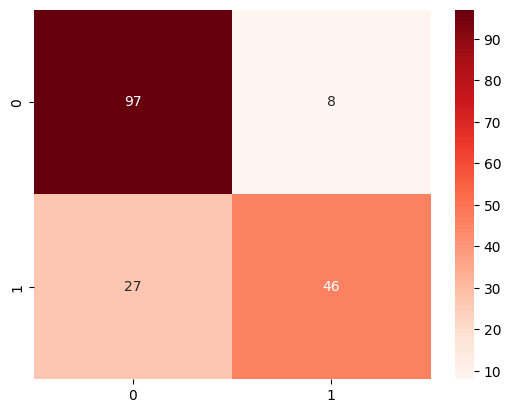

In [336]:
CM_knn = confusion_matrix(Y_test, y_pred)
print("Confusion Matrix:\n", CM_knn)
sns.heatmap(CM_knn, annot= True, cmap= 'Reds')

##### Model Logistic Regression

Menggunakan Gridsearch untuk Mencari nilai Optimal Model Logistic Regression

In [310]:
LR_params = {'penalty' : ['l1', 'l2', 'elasticnet', 'None'],
             'dual' : [True, False],
             'tol' : [1e-7,1e-6,1e-5,1e-4,1e-3,1e-2,1e-1,1e-0,1e+1,1e+2,1e+3,1e+4,1e+5],
             'solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']}

LR = LogisticRegression()
GRS = GridSearchCV(LR, LR_params, cv=5)
GRS.fit(X_train, Y_Train)

print(GRS.best_params_)
print(GRS.best_score_)

{'dual': False, 'penalty': 'l1', 'solver': 'saga', 'tol': 100.0}
0.7960307298335467


Membuat prediksi

In [ ]:
LR = LogisticRegression(dual=False, penalty='l2', solver='sag', tol=1000.0)
LR.fit(X_train,Y_Train)
LR_predict = LR.predict(X_test)
LR_predict_train = LR.predict(X_train)

In [306]:
print("Classification Report for the test group : \n")
print(classification_report(Y_Test,LR_predict),"\n\n")
print("Classification Report for the train group (to check if there is any overfitting): \n")
print(classification_report(Y_Train,LR_predict_train),"\n\n")

Classification Report for the test group : 

              precision    recall  f1-score   support

           0       0.85      0.89      0.87       105
           1       0.83      0.78      0.80        73

    accuracy                           0.84       178
   macro avg       0.84      0.83      0.84       178
weighted avg       0.84      0.84      0.84       178
 


Classification Report for the train group (to check if there is any overfitting): 

              precision    recall  f1-score   support

           0       0.81      0.88      0.85       444
           1       0.77      0.66      0.71       267

    accuracy                           0.80       711
   macro avg       0.79      0.77      0.78       711
weighted avg       0.80      0.80      0.80       711
 




In [307]:
test_accuracy = accuracy_score(Y_Test, LR_predict)
print(f"Accuracy Score for the test group: {test_accuracy:.4f}\n")
train_accuracy = accuracy_score(Y_Train, LR_predict_train)
print(f"Accuracy Score for the train group: {train_accuracy:.4f}\n")

Accuracy Score for the test group: 0.8427

Accuracy Score for the train group: 0.7989



[[93 12]
 [16 57]]


<Axes: >

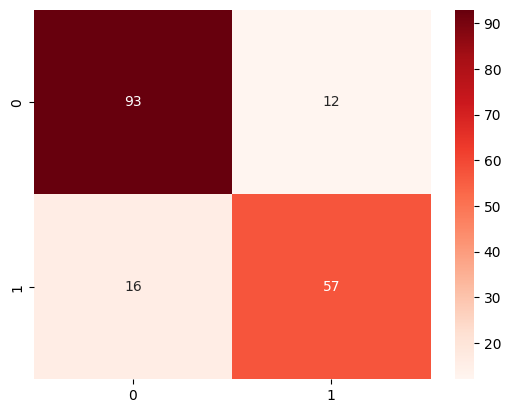

In [312]:
CM_LR = confusion_matrix(Y_Test, LR_predict)
print(CM_LR)
sns.heatmap(CM_LR, annot= True, cmap= 'Reds')

##### Model Support Vector Machine

Applying GridSearch Model on SVM Classifier:

In [313]:
SVM_params = {
    'C' : [0.1, 1, 10, 100],
    'kernel' : ['linear', 'rbf'],
    'gamma' : ['scale', 'auto'],
    'degree' : [2, 3, 4]
}

GRS = GridSearchCV(svm.SVC(), SVM_params, cv = 5)
GRS.fit(X_train, Y_Train)

print(GRS.best_params_)
print(GRS.best_score_)

{'C': 1, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}
0.8044617354476509


In [ ]:
SVM = svm.SVC(C=1, degree=2, gamma='scale', kernel='rbf')
SVM.fit(X_train, Y_Train)
SVM_Pred = SVM.predict(X_test)
SVM_pred_train = SVM.predict(X_train)

In [315]:
print('classification Report untuk Grup Data Test : \n')
print(classification_report(Y_Test, SVM_Pred), "\n\n")
print('Clasification Report untuk Grup Data Train: \n')
print(classification_report(Y_Train, SVM_pred_train), '\n\n')

classification Report untuk Grup Data Test : 

              precision    recall  f1-score   support

           0       0.80      0.97      0.88       105
           1       0.94      0.66      0.77        73

    accuracy                           0.84       178
   macro avg       0.87      0.81      0.83       178
weighted avg       0.86      0.84      0.84       178
 


Clasification Report untuk Grup Data Train: 

              precision    recall  f1-score   support

           0       0.83      0.95      0.88       444
           1       0.88      0.67      0.76       267

    accuracy                           0.84       711
   macro avg       0.85      0.81      0.82       711
weighted avg       0.85      0.84      0.84       711
 




In [316]:
test_accuracy = accuracy_score(Y_Test, SVM_Pred)
print(f"Skor Akurasi untuk grup data tes adalah: {test_accuracy:.4f}\n")
train_accuracy = accuracy_score(Y_Train, SVM_pred_train)
print(f"Skor Akurasi untuk grup data train adalah: {train_accuracy:.4f}\n")

Skor Akurasi untuk grup data tes adalah: 0.8427

Skor Akurasi untuk grup data train adalah: 0.8411



[[102   3]
 [ 25  48]]


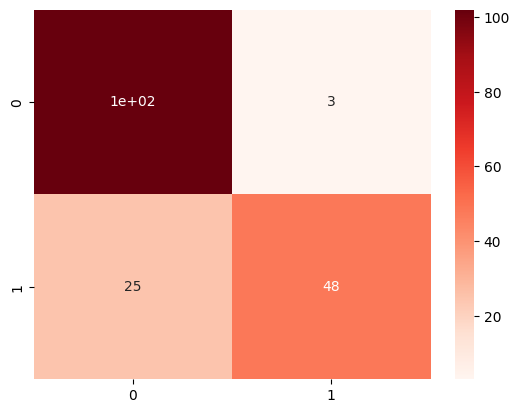

In [317]:
CM_SVM = confusion_matrix(Y_Test, SVM_Pred)
print(CM_SVM)
sns.heatmap(CM_SVM, annot=True, cmap='Reds')
plt.show()

##### Model CatBoost Model

Applying GridSearch Model on  CatBoost Model:

In [ ]:
CB_params = {
    'learning_rate' : [0.05, 0.1],
    'depth' : [3, 5, 7],
    'iterations' : [100, 200, 250],
    'bagging_temperature' : [0.5, 1.0]
}

CB = CatBoostClassifier()
GRS = GridSearchCV(CB, CB_params, cv = 5)
GRS.fit(X_train, Y_Train)

# Print the best parameters and best score
print(GRS.best_params_)
print(GRS.best_score_)

0:	learn: 0.6745435	total: 160ms	remaining: 15.9s
1:	learn: 0.6599342	total: 161ms	remaining: 7.88s
2:	learn: 0.6459750	total: 161ms	remaining: 5.21s
3:	learn: 0.6330061	total: 162ms	remaining: 3.88s
4:	learn: 0.6211076	total: 162ms	remaining: 3.08s
5:	learn: 0.6110184	total: 162ms	remaining: 2.54s
6:	learn: 0.6029510	total: 163ms	remaining: 2.16s
7:	learn: 0.5950375	total: 163ms	remaining: 1.87s
8:	learn: 0.5867441	total: 163ms	remaining: 1.65s
9:	learn: 0.5769779	total: 164ms	remaining: 1.47s
10:	learn: 0.5691180	total: 164ms	remaining: 1.33s
11:	learn: 0.5617257	total: 164ms	remaining: 1.21s
12:	learn: 0.5565958	total: 165ms	remaining: 1.1s
13:	learn: 0.5491610	total: 165ms	remaining: 1.01s
14:	learn: 0.5421566	total: 166ms	remaining: 938ms
15:	learn: 0.5369710	total: 166ms	remaining: 871ms
16:	learn: 0.5319429	total: 166ms	remaining: 812ms
17:	learn: 0.5280021	total: 167ms	remaining: 760ms
18:	learn: 0.5250412	total: 167ms	remaining: 712ms
19:	learn: 0.5209781	total: 167ms	remainin

In [319]:
CB = CatBoostClassifier(bagging_temperature = 0.5, depth=5, iterations = 300, learning_rate=0.05)
CB.fit(X_train, Y_Train)
CB_Pred = CB.predict(X_test)
CB_Pred_Train = CB.predict(X_train)

0:	learn: 0.6601080	total: 2.12ms	remaining: 634ms
1:	learn: 0.6311430	total: 4.23ms	remaining: 630ms
2:	learn: 0.6167354	total: 6.28ms	remaining: 622ms
3:	learn: 0.5970799	total: 8.6ms	remaining: 636ms
4:	learn: 0.5786083	total: 10.6ms	remaining: 625ms
5:	learn: 0.5616867	total: 12.3ms	remaining: 605ms
6:	learn: 0.5478479	total: 13.9ms	remaining: 582ms
7:	learn: 0.5332833	total: 15.6ms	remaining: 568ms
8:	learn: 0.5185910	total: 17.1ms	remaining: 554ms
9:	learn: 0.5058943	total: 18.7ms	remaining: 542ms
10:	learn: 0.5011007	total: 19.7ms	remaining: 518ms
11:	learn: 0.4914783	total: 22ms	remaining: 527ms
12:	learn: 0.4816957	total: 23.9ms	remaining: 527ms
13:	learn: 0.4728767	total: 25.4ms	remaining: 519ms
14:	learn: 0.4698763	total: 26.5ms	remaining: 503ms
15:	learn: 0.4636987	total: 28ms	remaining: 497ms
16:	learn: 0.4570866	total: 29.6ms	remaining: 493ms
17:	learn: 0.4514394	total: 31.2ms	remaining: 488ms
18:	learn: 0.4467553	total: 32.7ms	remaining: 484ms
19:	learn: 0.4440713	total:

In [320]:
print('Clasification Report for the test group : \n')
print(classification_report(Y_Test, CB_Pred), '\n\n')
print('Clasification Report for the train group (to check if there is any overfitting): \n')
print(classification_report(Y_Train, CB_Pred_Train), '\n\n')

Clasification Report for the test group : 

              precision    recall  f1-score   support

           0       0.82      0.95      0.88       105
           1       0.91      0.70      0.79        73

    accuracy                           0.85       178
   macro avg       0.87      0.83      0.84       178
weighted avg       0.86      0.85      0.84       178
 


Clasification Report for the train group (to check if there is any overfitting): 

              precision    recall  f1-score   support

           0       0.90      0.97      0.93       444
           1       0.94      0.82      0.87       267

    accuracy                           0.91       711
   macro avg       0.92      0.89      0.90       711
weighted avg       0.91      0.91      0.91       711
 




In [321]:
test_accuracy = accuracy_score(Y_Test, CB_Pred)
print(f"Skor Akurasi untuk grup data test: {test_accuracy:.4f}\n")
train_accuracy = accuracy_score(Y_Train, CB_Pred_Train)
print(f"Skor Akurasi untuk grup data train: {train_accuracy:.4f}\n")

Skor Akurasi untuk grup data test: 0.8483

Skor Akurasi untuk grup data train: 0.9114



[[100   5]
 [ 22  51]]


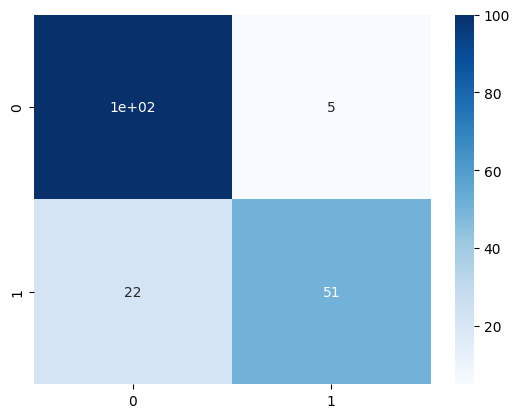

In [322]:
CM_CB = confusion_matrix(Y_Test, CB_Pred)
print(CM_CB)
sns.heatmap(CM_CB, annot=True, cmap = 'Blues')
plt.show()

##### d. Berapa nilai evaluasi dari masing masing model pada data uji? Apa arti dari masing masing metrik evaluasi tersebut?

##### e. Bandingkan hasil dari ketiga algortima tersebut, mana yang paling bagus? Berikan ulasan kira-kira apa yang menyebabkan metode tersebut dapat memprediksi data anda dengan baik?